In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper, provideData
from Utils.transform import cutOut


tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (256,256)

channels = 5

slices = [256,256+256,256,256+256]
slices_label = [96,96+64,96,96+64]
cutOutFrame = cutOut(slices)
cutOutFrame_label = cutOut(slices_label)
years = [2017]
PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label]
batch_size = 50

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          channels = channels,
                          timeToPred = 30,
                          transform=TRANSFORMATION,
                          onlyUseYears=[2017],
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  30
SORTTING OUUUT 44417
[DEBUG] Data
[DEBUG] time to predict:  30
SORTTING OUUUT 17488


In [3]:
import numpy as np
def negative_Zeroinflated_Unet_BigBrainTime(input_shape,
                           activation_hidden="relu",
                           activation_output="relu"):
    
    inputs = Input(shape=input_shape) 

    conv00 = Conv2D(5, kernel_size=(5, 5), dilation_rate=3,padding="same")(inputs)
    conv00 = Activation(activation_hidden)(conv00)
    conv00 = Conv2D(10, kernel_size=(5, 5), strides=4,padding="same")(conv00)
    conv00 = Activation(activation_hidden)(conv00)
    
    
    conv01 = Conv2D(5, kernel_size=(5, 5), strides=(2,2),padding="same")(conv00)       
    conv01 = Activation(activation_hidden)(conv01)
    
    
    dilated_01 = Conv2D(5, kernel_size=(5, 5),padding="same",dilation_rate=2)(conv00)
    dilated_01 = Activation(activation_hidden)(dilated_01)
    dilated_01 = Conv2D(5, kernel_size=(3, 3), strides=(2,2),padding="same")(dilated_01)       
    dilated_01 = Activation(activation_hidden)(dilated_01)
    
    concatenate_01 = concatenate([conv01, dilated_01], axis=3)
    
    
    conv02 = Conv2D(10, kernel_size=(5, 5), strides=(2,2),padding="same")(concatenate_01)       
    conv02 = Activation(activation_hidden)(conv02)
    
    dilated_02 = Conv2D(10, kernel_size=(5, 5),padding="same",dilation_rate=2)(concatenate_01)
    dilated_02 = Activation(activation_hidden)(dilated_02)
    dilated_02 = Conv2D(10, kernel_size=(3, 3), strides=(2,2),padding="same")(dilated_02)       
    dilated_02 = Activation(activation_hidden)(dilated_02)
    
    concatenate_02 = concatenate([conv02, dilated_02], axis=3)
    
    conv03 = Conv2D(10, kernel_size=(5, 5), strides=(2,2),padding="same")(concatenate_02)       
    conv03 = Activation(activation_hidden)(conv03)
    
    dilated_03 = Conv2D(10, kernel_size=(5, 5),padding="same",dilation_rate=2)(concatenate_02)
    dilated_03 = Activation(activation_hidden)(dilated_03)
    dilated_03 = Conv2D(10, kernel_size=(3, 3), strides=(2,2),padding="same")(dilated_03)       
    dilated_03 = Activation(activation_hidden)(dilated_03)
    
    concatenate_03 = concatenate([conv03, dilated_03], axis=3)
    
    transpose_03 = Conv2DTranspose(10, kernel_size=(3, 3),dilation_rate=(2,2))(concatenate_03)       
    transpose_03 = Activation(activation_hidden)(transpose_03)
    transpose_03 = Conv2DTranspose(10, kernel_size=(3, 3),dilation_rate=(2,2))(transpose_03)       
    transpose_03 = Activation(activation_hidden)(transpose_03)
    
    concatenate_04 = concatenate([concatenate_02, transpose_03], axis=3)
    
    transpose_04 = Conv2DTranspose(10, kernel_size=(3, 3),dilation_rate=(2,2))(concatenate_04)       
    transpose_04 = Activation(activation_hidden)(transpose_04)
    transpose_04 = Conv2DTranspose(10, kernel_size=(3, 3),dilation_rate=(2,2))(transpose_04)       
    transpose_04 = Activation(activation_hidden)(transpose_04)
    transpose_04 = Conv2DTranspose(10, kernel_size=(3, 3),dilation_rate=(2,2))(transpose_04)       
    transpose_04 = Activation(activation_hidden)(transpose_04)
    transpose_04 = Conv2DTranspose(2, kernel_size=(3, 3),dilation_rate=(2,2))(transpose_04)       
    transpose_04 = Activation(activation_hidden)(transpose_04)
    

    concatenate_05 = concatenate([concatenate_01, transpose_04], axis=3)
    output = Conv2D(2, kernel_size=(3, 3),padding="same")(concatenate_05)

    
    layer_1 = Flatten()(output[:,:,:,:1])
    layer_2 = Flatten()(output[:,:,:,1:2])
    
    layer_1      = Dense(256)(layer_1)
    layer_2      = Dense(256)(layer_2)
    layer_1      = Dropout(0.1)(layer_1)
    layer_1      = Dropout(0.1)(layer_1)
    
    layer_1 = Dense(64*64,activation="sigmoid")(layer_1)
    layer_2 = Dense(64*64,activation="relu")(layer_2)
    layer_1 = tf.keras.layers.Reshape((64,64,1))(layer_1)
    layer_2 = tf.keras.layers.Reshape((64,64,1))(layer_2)
    input_dist= tf.concat([layer_1,layer_2],axis=-1)

    output_dist = tfp.layers.DistributionLambda(name="DistributionLayer",
                                                make_distribution_fn=lambda t: tfp.distributions.Independent(
                                                tfd.Mixture(
                                                    cat=tfd.Categorical(tf.stack([1-t[...,:1], t[...,:1]],axis=-1)),
                                                    components=[tfd.Deterministic(loc=tf.zeros_like(t[...,:1])),
                                                      tfd.Poisson(rate=tf.math.softplus(t[...,1:2]))])
                                                    ,name="ZeroInflated",reinterpreted_batch_ndims=0 ))
    output = output_dist(input_dist)
    model = Model(inputs=inputs, outputs=output)

    
    return model


In [4]:
modelPath = "./model_data/negative_Zeroinflated_Unet_BigBrainTime"
if not os.path.exists(modelPath):
    os.mkdir(modelPath)
    
model = negative_Zeroinflated_Unet_BigBrainTime((*dimension,5))
model.compile(loss=NLL, optimizer=Adam( lr= 1e-2 ))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 5)  630         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 5)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 10)   1260        activation[0][0]                 
______________________________________________________________________________________________

In [5]:
from tensorflow.keras.callbacks import *

modelname = os.path.join(modelPath,'model-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5')
checkpoint = ModelCheckpoint(modelname, verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 
history = model.fit(train,validation_data=test,epochs=50,callbacks=checkpoint)


Epoch 1/50


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


888/888 [==============================] - 226s 255ms/step - loss: 2.0636 - val_loss: 1.4458
Epoch 2/50
888/888 [==============================] - 229s 258ms/step - loss: 1.3732 - val_loss: 1.4351
Epoch 3/50
888/888 [==============================] - 227s 256ms/step - loss: 1.3691 - val_loss: 1.4080
Epoch 4/50
888/888 [==============================] - 224s 252ms/step - loss: 1.3797 - val_loss: 1.5502
Epoch 5/50
888/888 [==============================] - 225s 253ms/step - loss: 1.3636 - val_loss: 1.4006
Epoch 6/50
888/888 [==============================] - 223s 251ms/step - loss: 1.3578 - val_loss: 1.3984
Epoch 7/50
888/888 [==============================] - 223s 252ms/step - loss: 1.3537 - val_loss: 1.3701
Epoch 8/50
888/888 [==============================] - 222s 250ms/step - loss: 1.3313 - val_loss: 1.3750
Epoch 9/50
888/888 [==============================] - 222s 250ms/step - loss: 1.3190 - val_loss: 1.4133
Epoch 10/50
888/888 [==============================] - 223s 251ms/step - lo

NameError: name 'trainer' is not defined

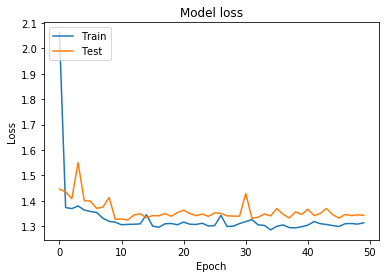

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
History_ = history.history
def plotHistory(history):


    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory(History_)

In [11]:

pred = None
label = None
pred_ = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
prediction = []
for x,y in test:
    for i in range(batch_size):
        if y[i,:,:,:].max() >= 0:
            pred = model(np.array([x[i,:,:,:]]))
            prediction.append(pred)
            mean.append(pred.mean())
            stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
    if len(label) >= pred_:
        break
        


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


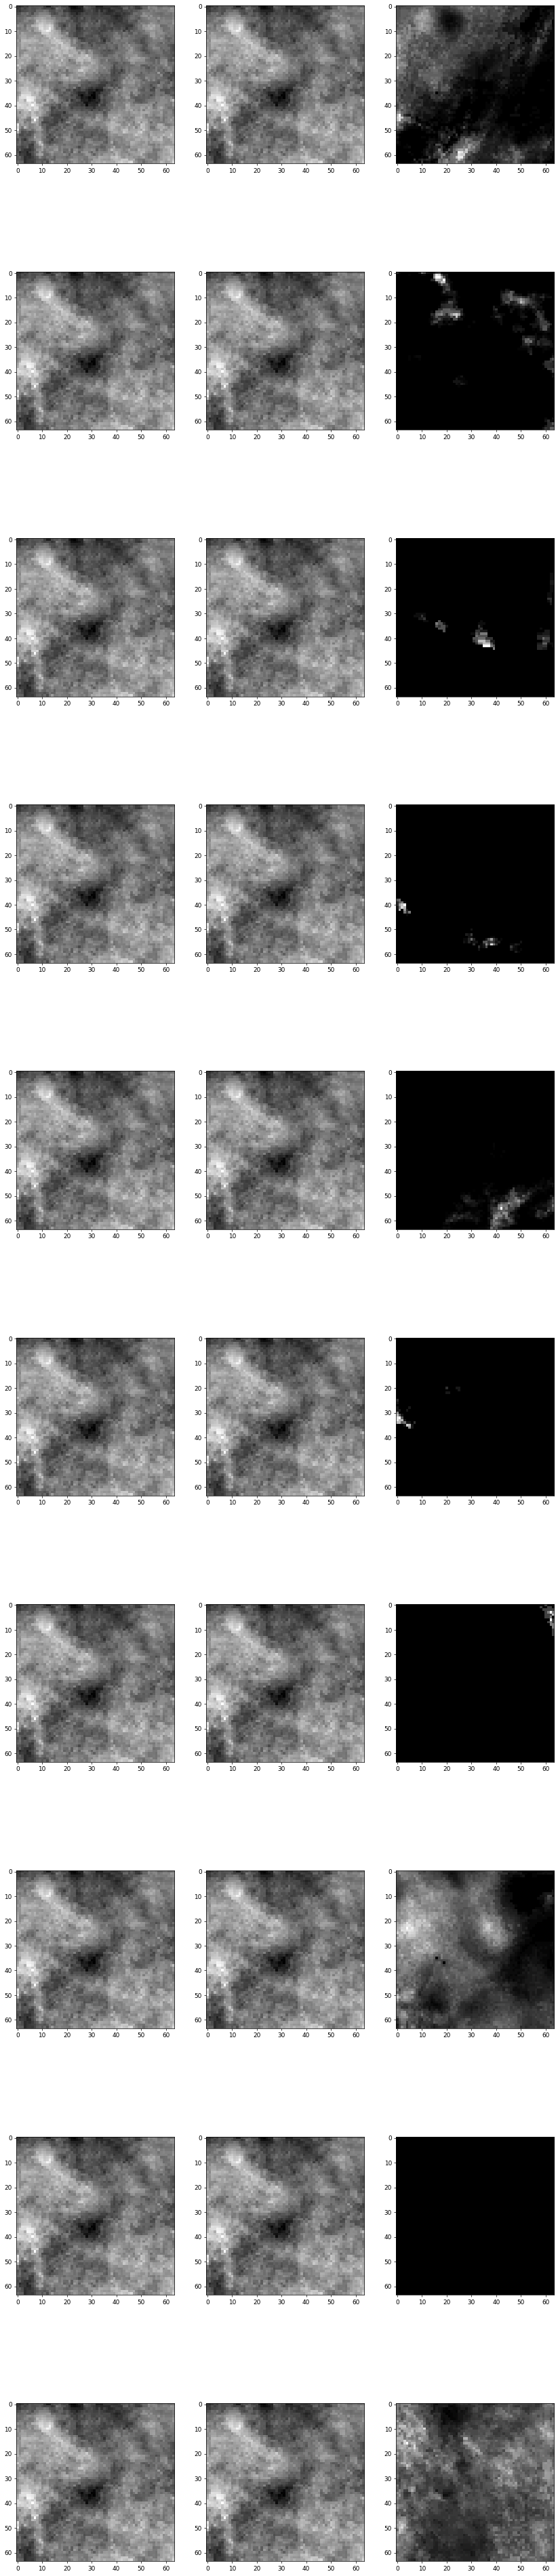

In [12]:
fig, axes = plt.subplots(10, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 10:
        break
    axes[batch,1].imshow(img[0,:,:,0],cmap="gray")
    axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")

In [ ]:
def map_Dist_To_Rain(prediction,label):
    
    x,y,t      = prediction[0][0,:,:,:].shape
    rain_true  = np.zeros((x,y,t))
    rain_false = rain_true.copy()
    
    
    
    ones = np.ones((x,y))
    zeros = np.zeros((x,y,t))
    value_map = np.array([ones * i for i in range(256)])
    value_map = value_map.transpose(1,2,0)
    for i,pred in enumerate(prediction):
        ones = np.ones((x,y,t)) * 3/255
        #print((np.array(pred.prob(ones))).max(axis=-1) )
        probs = np.array(pred.prob(value_map))
        print(label[i].max())
        max_probs = probs.argmax(axis=-1)
        #print(probs[0,1,1,:].argmax())

        #print(probs.argmax(axis=-1))
        #print(probs.max(axis=-1))
        for j in range(256):
            for k in range(256):
                at = np.argmax(probs[0,k,j,:])
                if at > 0:
                #at = probs[0,k,j,:] .sum()
                    print("AATT",at)
        #    print(j,"min:",probs[:,:,:,j].min(),"max:",probs[:,:,:,j].max())
        #print(probs.shape)
        #print(probs)
        #print(pred.prob(0.0))
        print(np.array(pred.prob(label[i].max())).max() )
        print(np.array(pred.prob(label[i].max())).min() )
        if label[i].max() == 0:
            continue

        print(pred)
        s = (1-pred.cdf(zeros))
        
        #print(np.array(s).max(),np.array(probs.mean()).max(),label[i].max())
        
        plt.imshow(max_probs[0,:,:],cmap="gray")
        plt.show()
        plt.imshow(s[0,:,:,0],cmap="gray")
        plt.show()
        plt.imshow(label[i][:,:,0],cmap="gray")
        plt.show()
        break
    

map_Dist_To_Rain(prediction,label)
#print(prediction[0])

In [ ]:
a = np.arange(255)
print(label[0].max())
idx = np.where(label[0] == label[0].max() )
print(idx)
pred = prediction[0]
for i in range(255):
    a = np.ones((256,256,1)) * i
    #print(i,np.array(pred.prob(a)).max() )
#print(np.array(pred.mean())[33,28])
y = []
x = []
for i in range(256):
    x.append(i)
    #print(i,np.array(pred.prob(i))[0,33,28,:] )
    y.append(np.array(pred.prob(i))[0,idx[0],idx[1],0][0])
print(np.array(pred.mean())[0,idx[0],idx[1],0][0])

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(200,8.27)})
sns.barplot(x,y)



In [ ]:

propability = np.array(prediction[0].prob(label[0]))
mean = np.array(prediction[0].mean())


for i in range(256):
    for j in range(256):
        print(propability[0,i,j,0],"\t",mean[0,i,j,0],"\t",label[0][i,j,0],)


In [ ]:
print(propability.mean())